In [1]:
!pip install -r requirements.txt

In [25]:
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image, ImageDraw, ImageColor
from skimage.feature import canny
from imageio import imread
from skimage.color import rgb2gray
from skimage.filters import gaussian, try_all_threshold, threshold_otsu, threshold_mean, threshold_local
from skimage.morphology import binary_opening, binary_closing
from skimage.measure import regionprops
from skimage import measure
from scipy import ndimage as ndi

In [3]:
ITEMS_PATH = "./items"
DATASET_PATH = "./test_input/images"

# Обработка фотографий с отдельными предметами

corrector.jpg


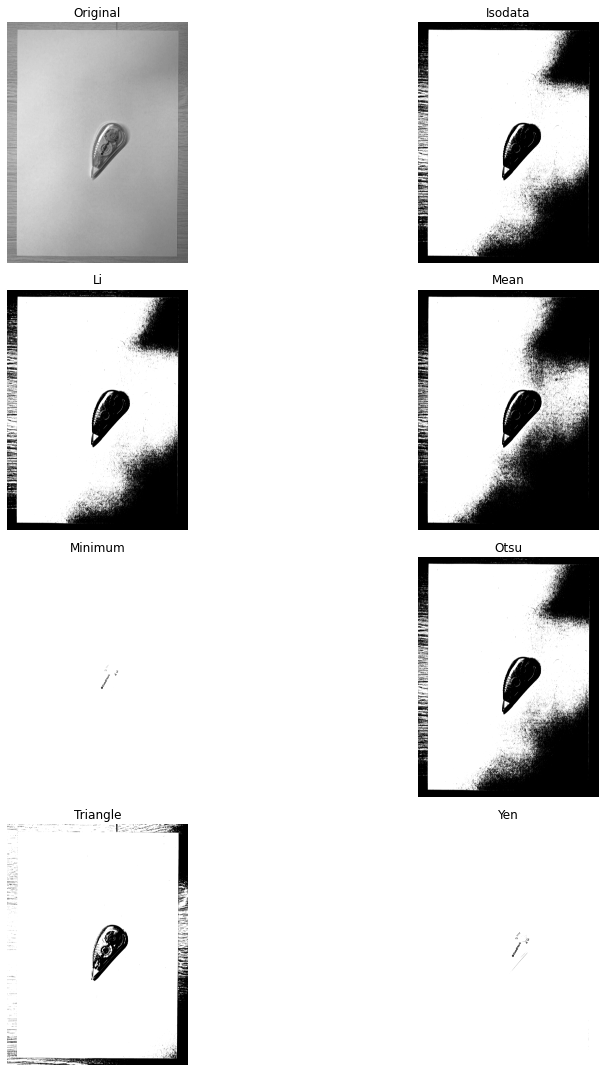

key.jpg


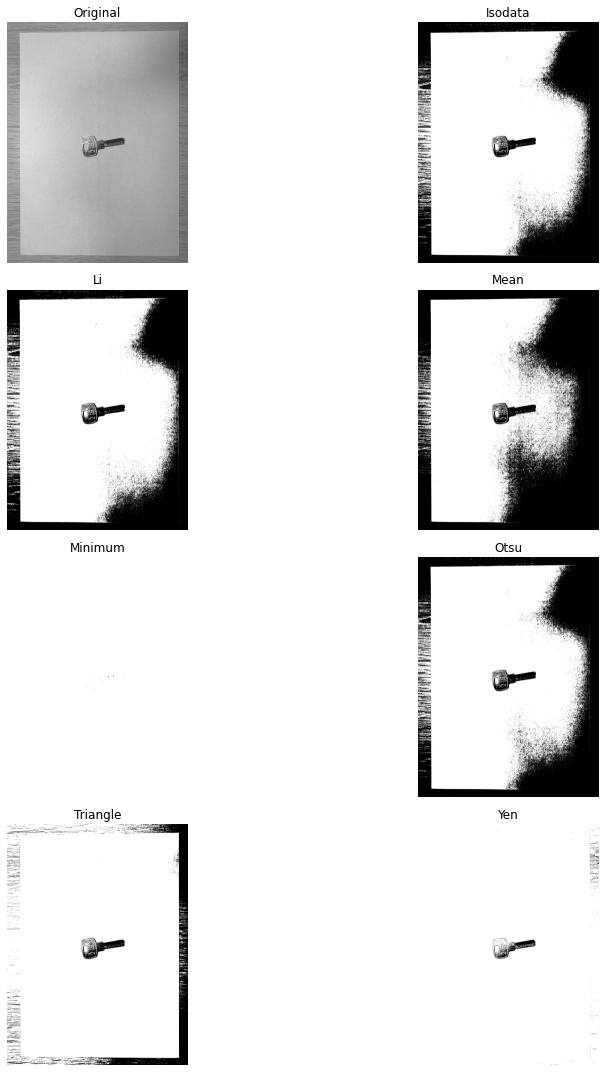

In [24]:
# посмотрим на разные методы бинаризации изображения
# как и ожидалось, бинаризация Оцу проявляет себя неплохо в сравнении с другими, попробуем поработать с ней
for img_path in ["corrector.jpg", "key.jpg"]:
    img = imread(os.path.join(ITEMS_PATH, img_path))
    fig, ax = try_all_threshold(rgb2gray(img), figsize=(15, 15), verbose=False)
    print(img_path)
    plt.show()

## Обрезка изображения по листу

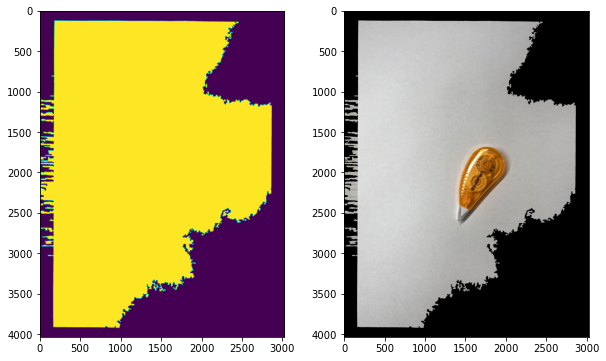

In [5]:
# попробуем вырезать все, что находится за пределами листа на изображении
img_path = os.path.join(ITEMS_PATH, "corrector.jpg")
img = imread(img_path)

img_blur_gray = rgb2gray(gaussian(img, sigma=1.5, channel_axis=True))
# бинаризация изображения
threshold_img = threshold_otsu(img_blur_gray)
result_image = img_blur_gray >= threshold_img
# морфологические операции
result_image = binary_opening(result_image, footprint=np.ones((10, 10)))
result_image = binary_closing(result_image, footprint=np.ones((10, 10)))

# выберем лист как наибольшую компоненту связности
labels = measure.label(result_image)
props = regionprops(labels)
mask_id = np.array([p.area for p in props]).argmax()
mask = (labels == (mask_id + 1))
# заполним дырки
mask = ndi.binary_fill_holes(mask)

# вырежем изображение по маске
visMask = (mask * 255).astype("uint8")
img = cv2.bitwise_and(img, img, mask=visMask)

ig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(mask)
ax[1].imshow(img)

# как видно из получившегося изображения, несмотря на достаточно равномерное освещение в кадре, 
# не получается обрезать лист достаточно хорошо, поэтому пока отложим эту идею

## Выбор компоненты, соответствующей объекту

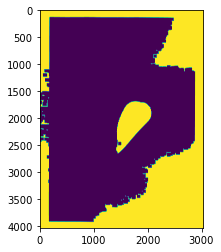

In [29]:
img_path = os.path.join(ITEMS_PATH, "corrector.jpg")
img = imread(img_path)

# не будем сжимать изображение, так как это ухудшает качество распознавания, а здесь мы хотим получить наиболее точные маски предметов
# img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)))

img_blur_gray = rgb2gray(gaussian(img, sigma=1.5, channel_axis=True))
# бинаризация изображения
threshold_img = threshold_otsu(img_blur_gray)
result_image = img_blur_gray <= threshold_img
# морфологические операции для улучшения полученной маски
result_image = binary_opening(result_image, footprint=np.ones((10, 10)))
result_image = binary_closing(result_image, footprint=np.ones((50, 50)))
plt.imshow(result_image)

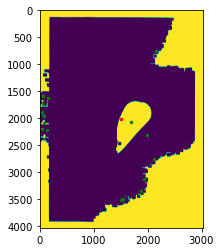

In [22]:
# на маске присутсвует много лишних компонент связности, попробуем отобрать нужную нам, используя то, что объект расположен в центре изображения
labels = measure.label(result_image)
props = regionprops(labels)
# посмотрим на центроиды всех компонент связности
plt.imshow(result_image)
center = (img.shape[0] / 2, img.shape[1] / 2)
plt.plot(center[1], center[0], '.r', markersize=5)
for prop in props:
    plt.plot(prop.centroid[1], prop.centroid[0], '.g', markersize=5)

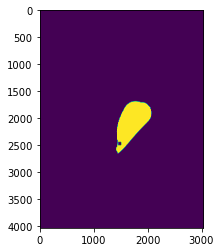

In [23]:
# выбираем компоненту, центроид которой расположен наиболее близко к центру (не рассматриваем компоненту стола)
dist = np.array([pow(center[0] - p.centroid[0], 2) + pow(center[1] - p.centroid[1], 2) for p in props if p.bbox[0] > 0])
mask_id = dist.argmin()
mask = (labels == (mask_id + 2))
plt.imshow(mask)

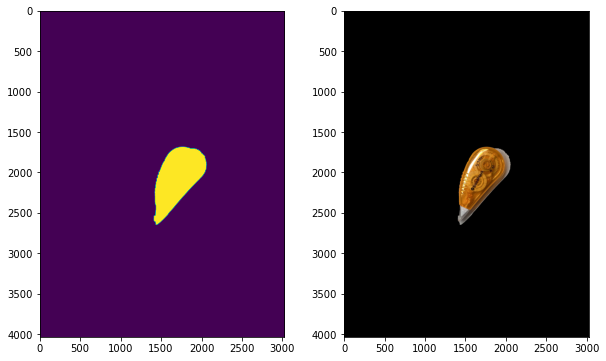

In [24]:
# еще раз закроем дыры в маске
mask = ndi.binary_fill_holes(mask)

# посмотрим, насколько хорошо с помощью полученной маски вырезается объект
visMask = (mask * 255).astype("uint8")
result_image = cv2.bitwise_and(img, img, mask=visMask)

ig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(mask)
ax[1].imshow(result_image)

In [78]:
# вынесем полученную последовательность действий в отдельную функцию
def process_object_img(img_path: str):
    img = imread(img_path)
    # предобработка изображения
    img = cv2.resize(img, (int(img.shape[1] / 1.5), int(img.shape[0] / 1.5)))
    img_blur_gray = rgb2gray(gaussian(img, sigma=1.5, channel_axis=True))
    # бинаризация изображения
    threshold_img = threshold_otsu(img_blur_gray)
    result_image = img_blur_gray <= threshold_img
    
    # морфологические операции для улучшения полученной маски
    # используем то, что мы заранее знаем возможные предметы, чтобы улучшить распознавание предметов со светлыми участками
    # TODO: подобрать универсальные операции (?)
    if os.path.basename(img_path) in ["key.jpg", "cream.jpg", "gum.jpg", "perfume.jpg", "card.jpg"]:
        result_image = binary_opening(result_image, footprint=np.ones((1, 1)))
        result_image = binary_closing(result_image, footprint=np.ones((40, 40)))
        result_image = binary_opening(result_image, footprint=np.ones((1, 1)))
    else:
        result_image = binary_opening(result_image, footprint=np.ones((10, 10)))
        result_image = binary_closing(result_image, footprint=np.ones((50, 50)))
        
    # попробуем отобрать нужную компоненту связности, используя то, что объект расположен в центре изображения
    labels = measure.label(result_image)
    props = regionprops(labels)
    center = (img.shape[0] / 2, img.shape[1] / 2)
    # выбираем компоненту, центроид которой расположен наиболее близко к центру (не рассматриваем компоненту стола)
    dist = np.array([pow(center[0] - p.centroid[0], 2) + pow(center[1] - p.centroid[1], 2) for p in props if p.bbox[0] > 0])
    mask_id = dist.argmin()
    mask = (labels == (mask_id + 2))
    # еще раз закроем дыры в маске
    mask = ndi.binary_fill_holes(mask)
    
    # получим из булевой матрицы изображение и обрежем его по баундинг боксу предмета
    mask_img = (mask * 255).astype("uint8")
    y1, x1, y2, x2 = props[mask_id + 1].bbox
    # вернем маску и обрезанное изображение предмета 
    result_image = img[y1:y2, x1:x2]
    vis_mask = mask_img[y1:y2, x1:x2]
    return result_image, vis_mask

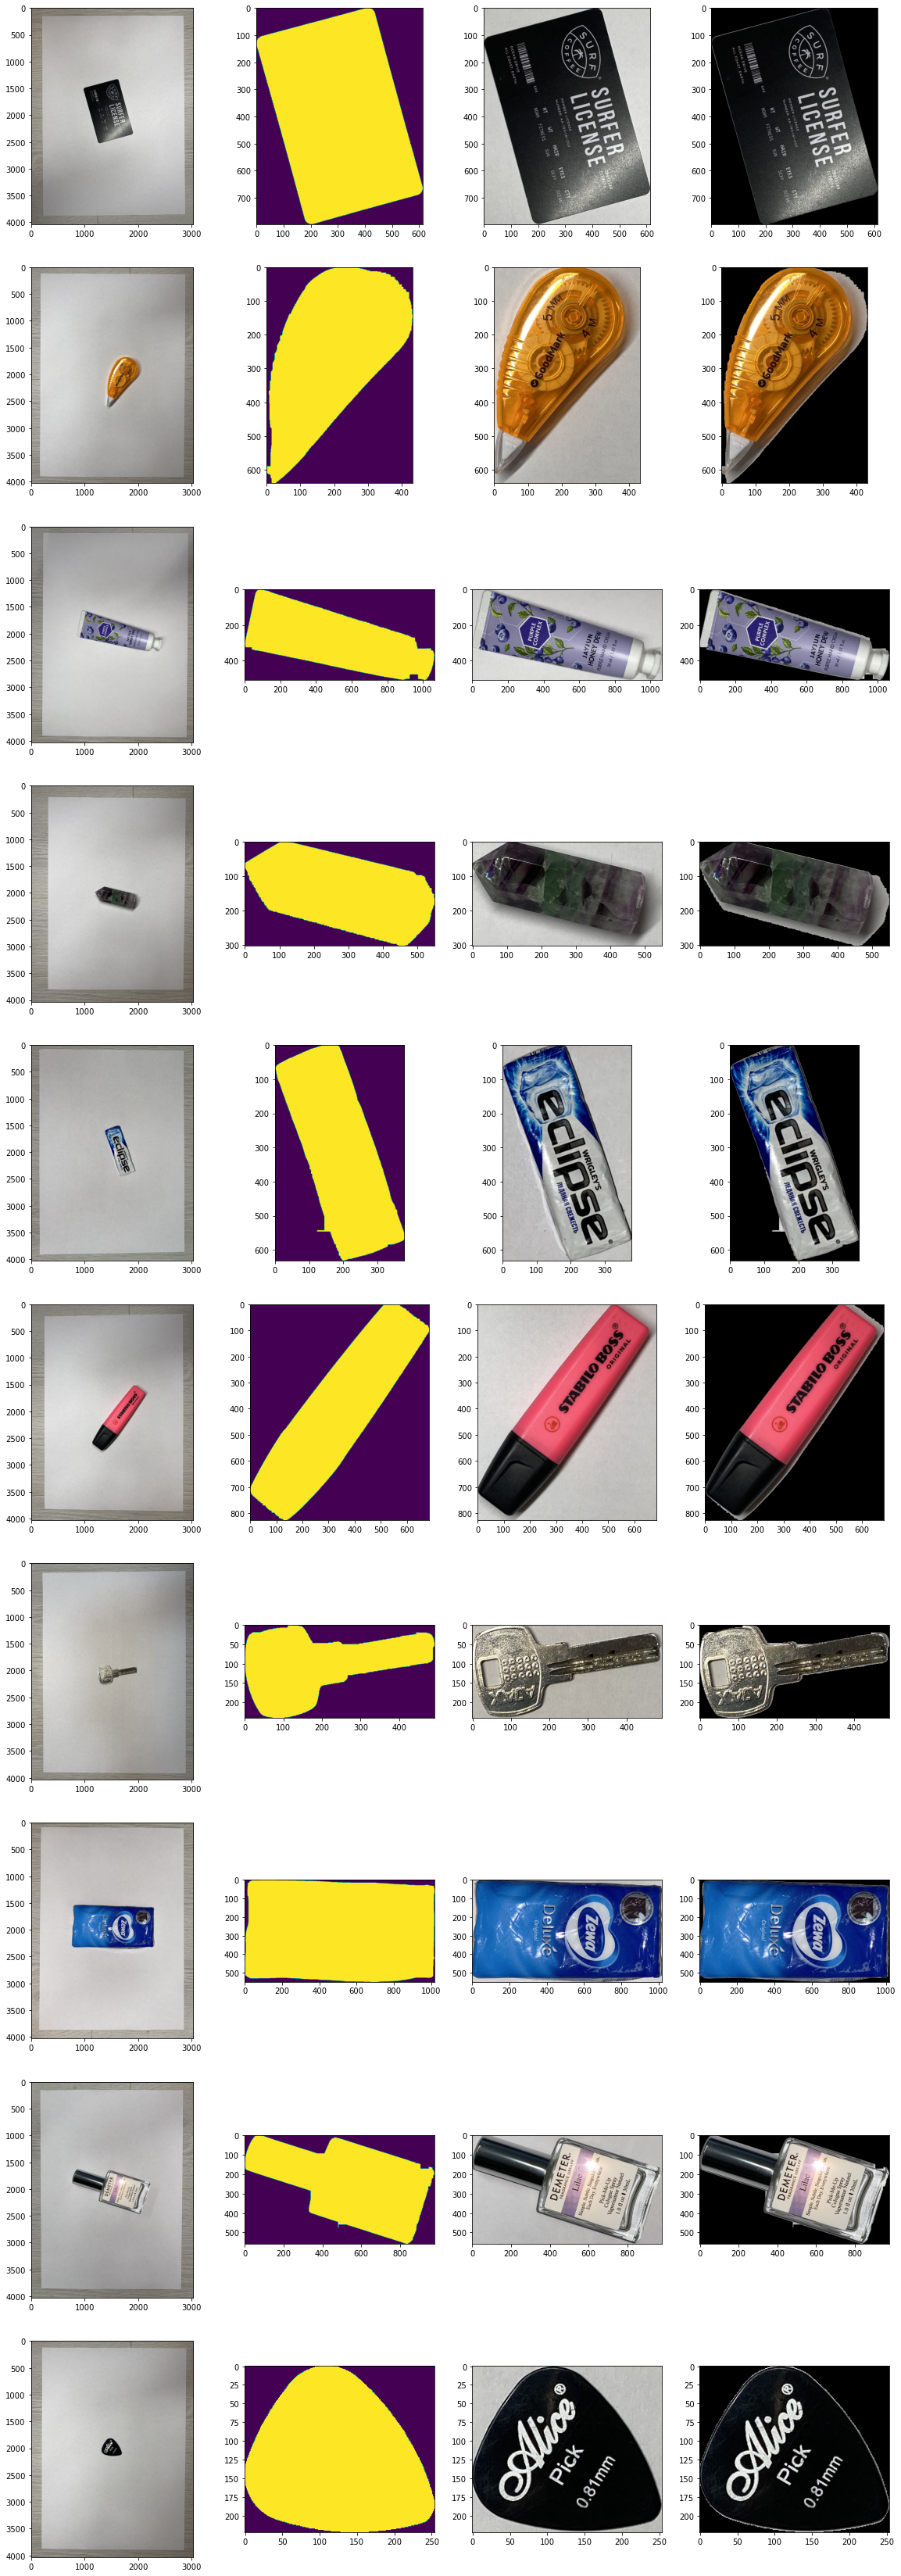

In [10]:
# добавим функцию в библиотеку и посмотрим результат ее работы на всех объектах
from intelligent_placer_lib.modules import object_data_preprocessing

fig, ax = plt.subplots(10, 4, figsize=(20, 60))
i = 0
for img_name in os.listdir(ITEMS_PATH):
    if not img_name == "background.jpg":
        img_path = os.path.join(ITEMS_PATH, img_name)
        result_image, mask = object_data_preprocessing.process_object_img(img_path)
        
        # сохраним полученные маски и обрезанные изображения объектов для дальнейшего использования
        cv2.imwrite(os.path.join("./masks", img_name), cv2.cvtColor(result_image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join("./masks", "mask_" + img_name), mask)

        ax.flatten()[i].imshow(imread(img_path))
        ax.flatten()[i + 1].imshow(mask)
        ax.flatten()[i + 2].imshow(result_image)
        ax.flatten()[i + 3].imshow(cv2.bitwise_and(result_image, result_image, mask=mask))      
        i += 4
plt.show()

In [17]:
MASKS_PATH = "./masks"

# Работа с тестовыми данными

## Получение изображений отдельных предметов

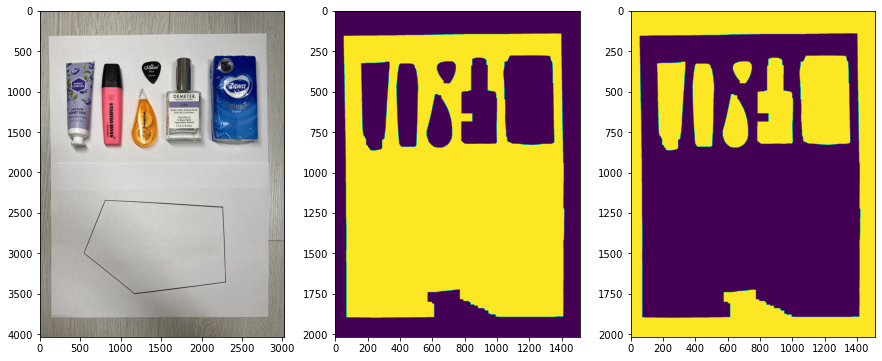

In [10]:
img_path = os.path.join(DATASET_PATH, "4.jpg")
img = imread(img_path)

# предобработка изображения
img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)))
img_blur_gray = rgb2gray(gaussian(img, sigma=1.5, channel_axis=True))

# бинаризуем изображение, получим компоненту соответствующую листу 
# с помощью морфологических операций добьемся закрашивания границ многоугольника
threshold_img = threshold_otsu(img_blur_gray)
mask_sheet = img_blur_gray >= threshold_img

mask_sheet = binary_opening(mask_sheet, footprint=np.ones((50, 50)))
visMask = (mask_sheet * 255).astype("uint8")
mask_sheet = cv2.bitwise_and(img_blur_gray, img_blur_gray, mask=visMask)
mask_sheet = binary_closing(mask_sheet, footprint=np.ones((20, 20)))
mask_image = ~mask_sheet

ig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(imread(img_path))
ax[1].imshow(mask_sheet)
ax[2].imshow(mask_image)

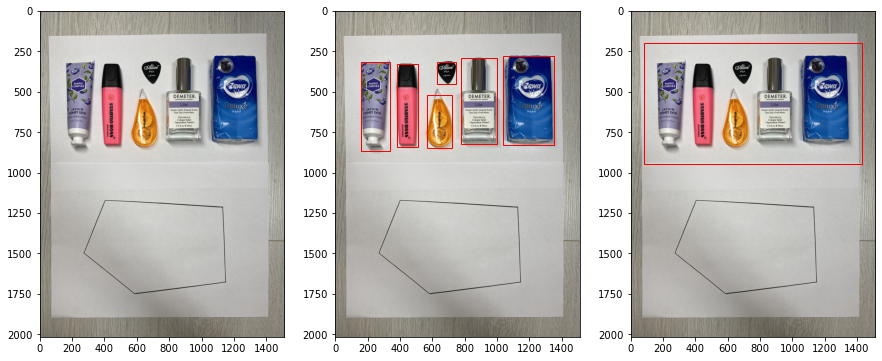

In [11]:
# найдем прямоугольник, ограничивающий все предметы, чтобы вырезать их с изображения
result_boxes = []
labels = measure.label(mask_image)
props = regionprops(labels)

ig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(img)
ax[1].imshow(img)
ax[2].imshow(img)

# заодно удостоверимся, что на изображении нашлись предметы
objects = 0
min_y, min_x, max_y, max_x = img.shape[0], img.shape[1], 0, 0
for prop in props:
    # не учитываем компоненту, образованную столом и тенью
    if prop.area > 1500 and prop.bbox[0] > 50:
        objects += 1
        prop_min_y, prop_min_x, prop_max_y, prop_max_x = prop.bbox
        ax[1].add_patch(patches.Rectangle((prop_min_x, prop_min_y),  prop_max_x - prop_min_x, prop_max_y - prop_min_y, linewidth=1, edgecolor='r', facecolor='none'))
        min_y, min_x, max_y, max_x = min(prop_min_y, min_y), min(prop_min_x, min_x), max(prop_max_y, max_y), max(prop_max_x, max_x)
        
# немного расширяем прямоугольник, чтобы не потерять компоненты предметов, которые не сохранились в маске
min_y, min_x, max_y, max_x = max(min_y - 80, 0), max(min_x - 80, 0), min(max_y + 80, img.shape[1]), min(max_x + 80,  img.shape[0]) 
ax[2].add_patch(patches.Rectangle((min_x, min_y),  max_x - min_x, max_y - min_y, linewidth=1, edgecolor='r', facecolor='none'))
plt.show()
if objects == 0:
    print("Ошибка: объекты не были найдены!")

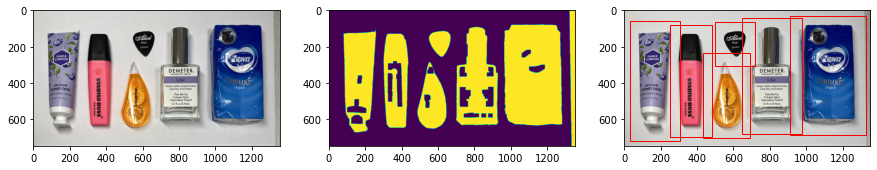

In [12]:
# обрезаем изображение
objects_image = img[min_y:max_y, min_x:max_x]
objects_image_gray = img_blur_gray[min_y:max_y, min_x:max_x]

# еще раз используем бинаризацию на вырезанных предметах, чтобы отделить их друг от друга
threshold_img = threshold_mean(objects_image_gray)
result_image = objects_image_gray <= threshold_img
result_image = binary_closing(result_image, footprint=np.ones((20, 20)))
                              
ig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].imshow(objects_image)
ax[1].imshow(result_image)
ax[2].imshow(objects_image)

# получаем массив баундинг боксов
result_boxes = []
labels = measure.label(result_image)
props = regionprops(labels)
for prop in props:
    if prop.area > 1000 and prop.bbox[0] > 50:
        box_min_y, box_min_x, box_max_y, box_max_x = prop.bbox
        box_min_y, box_min_x, box_max_y, box_max_x = max(box_min_y - 50, 0), max(box_min_x - 50, 0), min(box_max_y + 50, img.shape[1]), min(box_max_x + 50,  img.shape[0])
        result_boxes.append([box_min_y, box_min_x, box_max_y, box_max_x])
        ax[2].add_patch(patches.Rectangle((box_min_x, box_min_y),  box_max_x - box_min_x, box_max_y - box_min_y, linewidth=1, edgecolor='r', facecolor='none'))

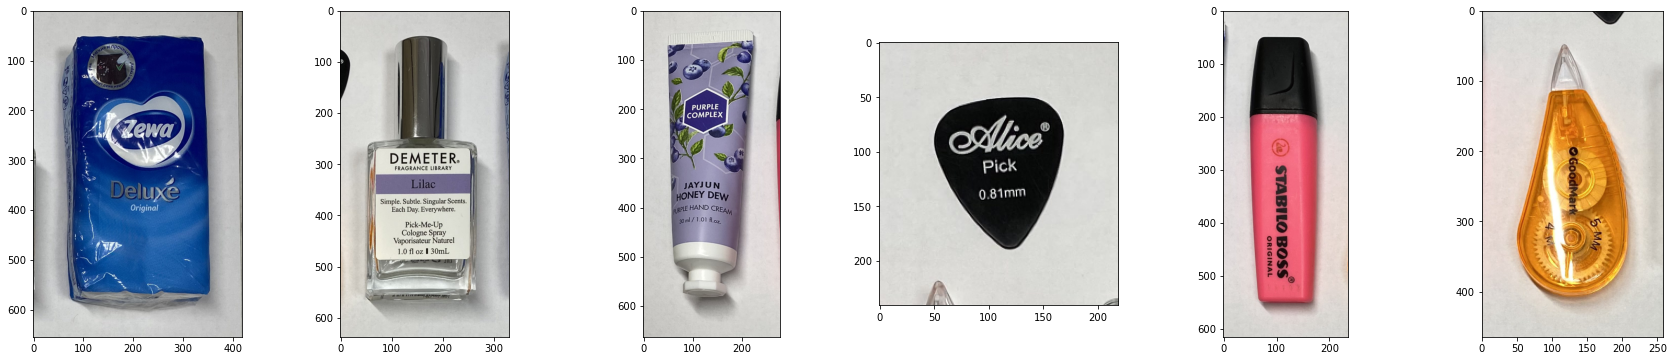

In [13]:
# получаем отдельные предметы
objects_color = []
for box in result_boxes:
    box_min_y, box_min_x, box_max_y, box_max_x = box
    objects_color.append(objects_image[box_min_y:box_max_y, box_min_x:box_max_x])

ig, ax = plt.subplots(1, len(objects_color), figsize=(len(objects_color) * 5, 6))
if len(objects_color) > 1:
    for i, object in enumerate(objects_color):
        ax[i].imshow(object)
else:
     ax.imshow(object)
plt.show()

## Получение маски многоугольника

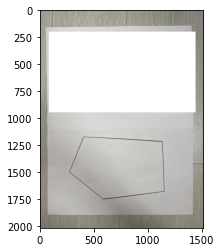

In [14]:
# закрасим область с предметами белым прямоугольником, чтобы они не влияли на поиск многоугольника
working_img = Image.fromarray(img) 
draw = ImageDraw.Draw(working_img)
draw.rectangle((min_x, min_y, max_x, max_y), fill=ImageColor.getrgb("white"))

image_without_objects = np.asarray(working_img)
plt.imshow(image_without_objects)

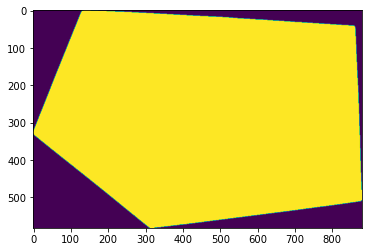

In [15]:
# применим детектор границ Кэнни и морфологические операции
img_blur_gray = rgb2gray(image_without_objects)
edges = canny(img_blur_gray, sigma=3, low_threshold=0.2, high_threshold = 0.3) 
edges = binary_closing(edges, footprint=np.ones((10, 10)))

# выберем компоненту, наибольшую по площади (все остальные - шум, так как мы исключили предметы)
labels = measure.label(edges)
props = regionprops(labels)
area = np.array([p.area for p in props if p.bbox[0] > 0])
# если компонента с наибольшей площадью слишком маленькая, считаем, что многоугольник не найден
if(area.max() < 1000):
    print("Ошибка: многоугольник не был найден!")
polygon_id = area.argmax()
polygon_mask = (labels == (polygon_id + 2))
# заполним многоугольник
polygon_mask = ndi.binary_fill_holes(polygon_mask)

# обрежем маску до многоугольника 
y1, x1, y2, x2 = props[polygon_id + 1].bbox
polygon_mask = polygon_mask[y1:y2, x1:x2]
plt.imshow(polygon_mask)

In [5]:
# оформим полученную послеовательность действий в виде функций и добавим их в библиотеку 
# посмотрим результат работы еще на нескольких тестовых изображениях
from intelligent_placer_lib.modules import detection

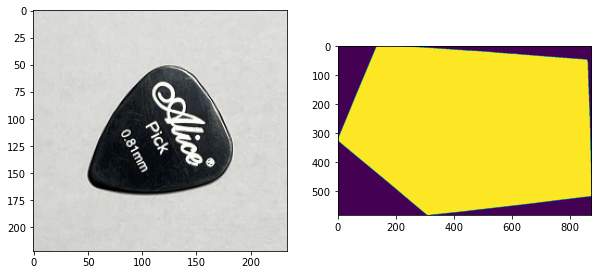

In [106]:
img_path = os.path.join(DATASET_PATH, "1.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
ig, ax = plt.subplots(1, len(objects) + 1, figsize=((len(objects) + 1) * 5, 6))
for i, object in enumerate(objects):
    ax[i].imshow(object)
ax[len(objects)].imshow(polygon_mask)

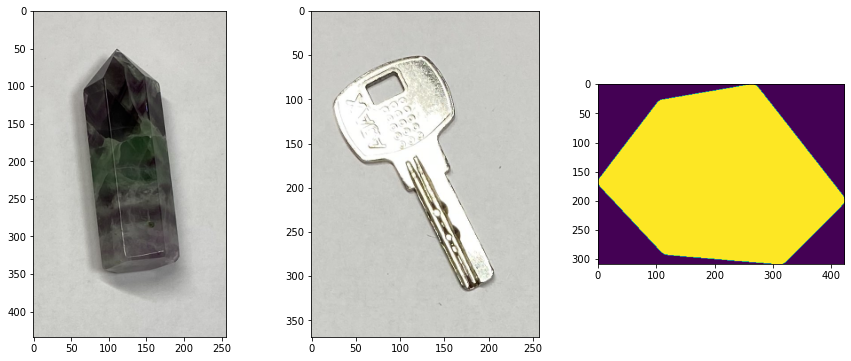

In [107]:
img_path = os.path.join(DATASET_PATH, "8.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
ig, ax = plt.subplots(1, len(objects) + 1, figsize=((len(objects) + 1) * 5, 6))
for i, object in enumerate(objects):
    ax[i].imshow(object)
ax[len(objects)].imshow(polygon_mask)

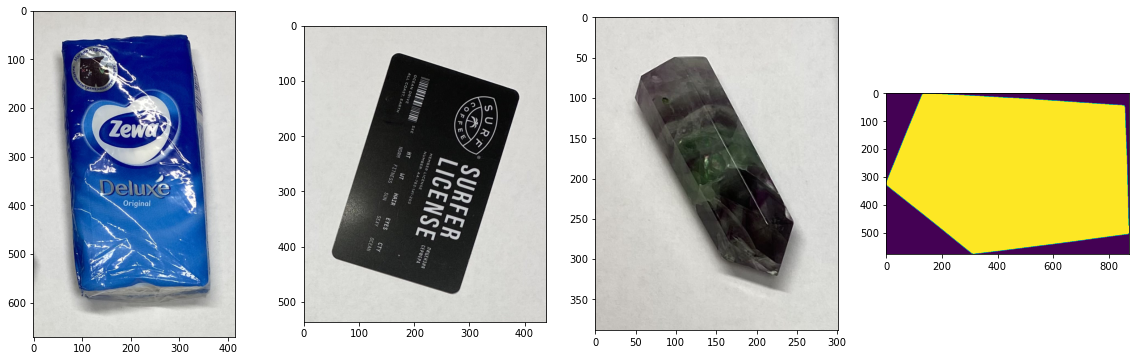

In [112]:
img_path = os.path.join(DATASET_PATH, "18.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
ig, ax = plt.subplots(1, len(objects) + 1, figsize=((len(objects) + 1) * 5, 6))
for i, object in enumerate(objects):
    ax[i].imshow(object)
ax[len(objects)].imshow(polygon_mask)

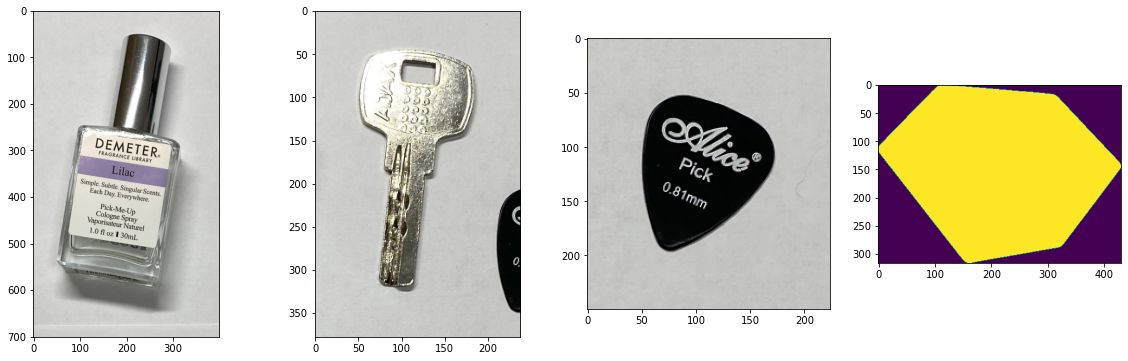

In [9]:
img_path = os.path.join(DATASET_PATH, "28.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
if not objects is None:
    ig, ax = plt.subplots(1, len(objects) + 1, figsize=((len(objects) + 1) * 5, 6))
    for i, object in enumerate(objects):
        ax[i].imshow(object)
    ax[len(objects)].imshow(polygon_mask)

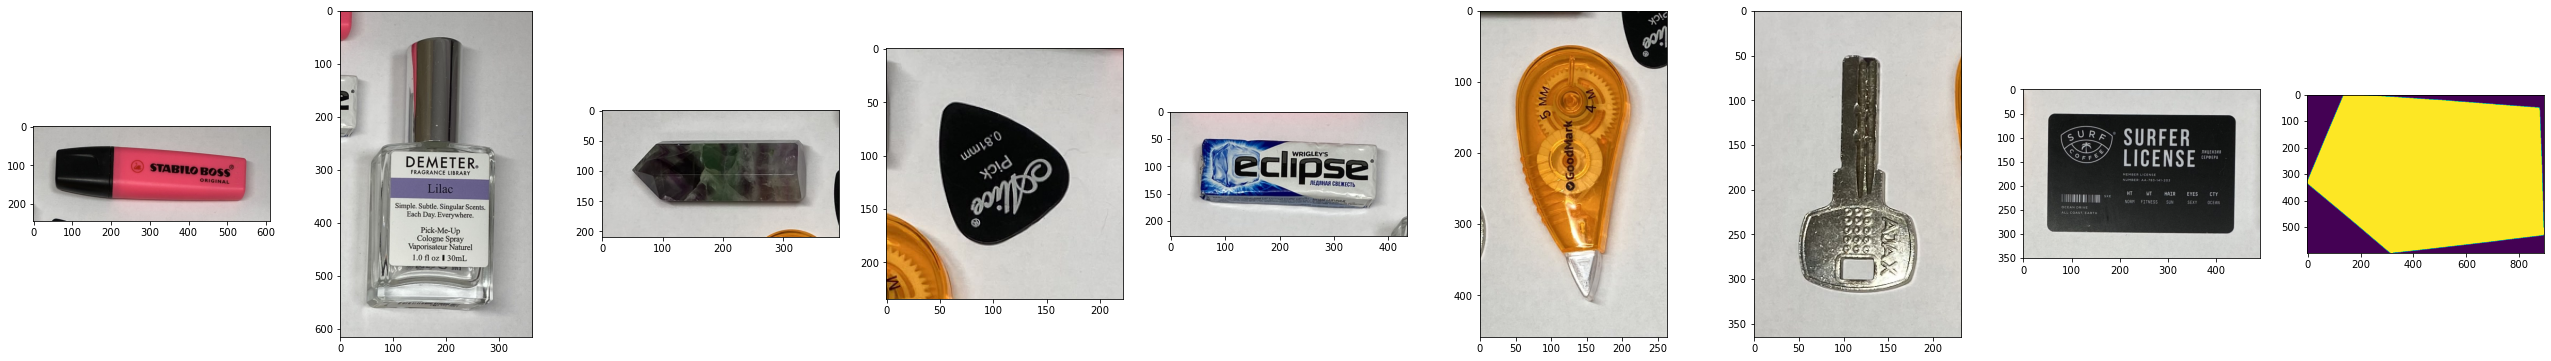

In [21]:
img_path = os.path.join(DATASET_PATH, "24.jpg")
objects, polygon_mask = detection.get_objects_and_polygon_mask(img_path)
if not objects is None:
    ig, ax = plt.subplots(1, len(objects) + 1, figsize=((len(objects) + 1) * 5, 6))
    for i, object in enumerate(objects):
        ax[i].imshow(object)
    ax[len(objects)].imshow(polygon_mask)

# Поиск гомографии

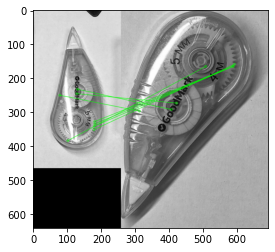

In [20]:
key_pattern = imread(os.path.join(MASKS_PATH, "corrector.jpg"))
key_mask = imread(os.path.join(MASKS_PATH, "mask_corrector.jpg"))

key_test_color = objects_color[5]
key_test = cv2.cvtColor(key_test_color, cv2.COLOR_RGB2GRAY)
key_pattern = cv2.cvtColor(key_pattern, cv2.COLOR_RGB2GRAY)

# ищем особые точки на изображениях, используя дескриптор SIFT
sift = cv2.SIFT_create()
kp_first_image, des_first_image = sift.detectAndCompute(key_test, None)
kp_second_image, des_second_image= sift.detectAndCompute(key_pattern, None)

# ищем совпадения особых точек
flann = cv2.FlannBasedMatcher(dict(algorithm = 1, trees = 5), dict(checks = 50))
matches = flann.knnMatch(des_first_image, des_second_image, k = 2)
good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]

# ищем гомографию
first_pts = np.float32([kp_first_image[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
second_pts = np.float32([kp_second_image[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
matrix, mask_hom = cv2.findHomography(first_pts, second_pts, cv2.RANSAC, 5.0)
matchesMask = mask_hom.ravel().tolist()
    
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = None,
                   matchesMask = matchesMask,
                   flags = 2)
img3 = cv2.drawMatches(key_test, kp_first_image, key_pattern, kp_second_image, good_matches, None, **draw_params)
plt.imshow(img3, 'gray')
plt.show()

TODO: попробовать другие дескрипторы, доделать преобразование

# TODO: Укладка предметов